In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error

In [2]:
model = load_model('model12_waterflow.hdf5')

In [3]:
df = pd.read_csv('Sub0-RAW.csv')
df.head()

,Dates,Year,Month,Day,Hours,Precipitation,Temperature,Outflow
0,10/1/1980,1980,10,1,0:00:00,0.0,102.992,5.0
1,10/1/1980,1980,10,1,1:00:00,0.0,97.790,5.0
2,10/1/1980,1980,10,1,2:00:00,0.0,92.588,5.0
3,10/1/1980,1980,10,1,3:00:00,0.0,87.404,5.0
4,10/1/1980,1980,10,1,4:00:00,0.0,85.172,5.0


In [4]:
train_cols = ["Precipitation","Temperature","Outflow"]

In [5]:
new_df = df.filter(train_cols, axis=1)

In [6]:
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df['Outflow(t+%d)' %(i+1)] = new_df['Outflow'].shift(-(i+1))
    return df

In [7]:
def timeseries(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,))
    Y_values_actual = np.zeros((input_size_0,))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1, 0]
        Y_values_actual[i] = Y_actual[time_steps+i-1, 0]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

In [8]:
lag_df = lag_seq(new_df, 3)
lag_df.dropna(inplace=True)

In [9]:
lag_df

,Precipitation,Temperature,Outflow,Outflow(t+1),Outflow(t+2),Outflow(t+3)
0,0.0,102.992,5.0,5.0,5.0,5.0
1,0.0,97.790,5.0,5.0,5.0,5.0
2,0.0,92.588,5.0,5.0,5.0,5.0
3,0.0,87.404,5.0,5.0,5.0,5.0
4,0.0,85.172,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...
185536,0.0,47.228,22.0,27.0,29.0,30.0
185537,0.0,50.054,27.0,29.0,30.0,29.0
185538,0.0,52.880,29.0,30.0,29.0,29.0
185539,0.0,54.284,30.0,29.0,29.0,31.0


In [10]:
#label_cols = ["Outflow(t+1)", "Outflow(t+2)", "Outflow(t+3)"]
label_cols = ["Outflow(t+3)"]

In [11]:
#Min Max scalr normalizing
xtrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
xtest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))

In [12]:
#Splitting training and test data
df_train, df_test = train_test_split(lag_df, train_size=0.8, test_size=0.2, shuffle=False)
x_train = df_train.loc[:,train_cols].values
y_train = df_train.loc[:,label_cols].values
x_test = df_test.loc[:,train_cols].values
y_test = df_test.loc[:,label_cols].values

In [13]:
x_train.shape, y_test.shape

((148432, 3), (37109, 1))

In [14]:
y_train_actual = y_train
y_test_actual = y_test

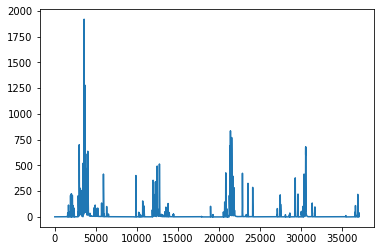

In [15]:
plt.figure()
plt.plot(y_test_actual)
plt.show()

In [16]:
#Normalizing training data
x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)
y_train_nor = ytrain_min_max_scaler.fit_transform(y_train)

# Normalizing test data
x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
y_test_nor = ytest_min_max_scaler.fit_transform(y_test)

In [17]:
#Building timeseries
X_Train, Y_Train, Y_train_actual = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=18, out_steps=1)
X_Test, Y_Test, Y_test_actual = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=18, out_steps=1)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



length of time-series i/o (148414, 18, 3) (148414,)



length of time-series i/o (37091, 18, 3) (37091,)


In [18]:
X_Train.shape,Y_Train.shape

((148414, 18, 3), (148414,))

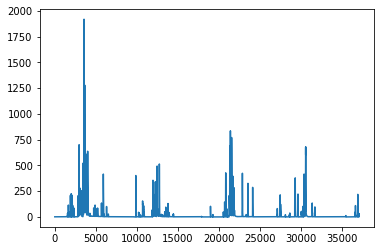

In [19]:
plt.figure()
plt.plot(Y_test_actual)
plt.show()

In [20]:
history = model.fit(X_Train, Y_Train, epochs=8,
                   validation_data=(X_Test, Y_Test))

Epoch 1/8
4638/4638 [==============================] - 57s 12ms/step - loss: 3.2281e-05 - val_loss: 4.1861e-05
Epoch 2/8
4638/4638 [==============================] - 54s 12ms/step - loss: 3.1602e-05 - val_loss: 3.6487e-05
Epoch 3/8
4638/4638 [==============================] - 49s 10ms/step - loss: 2.8799e-05 - val_loss: 4.5005e-05
Epoch 4/8
4638/4638 [==============================] - 51s 11ms/step - loss: 2.8240e-05 - val_loss: 2.8262e-05
Epoch 5/8
4638/4638 [==============================] - 52s 11ms/step - loss: 2.8870e-05 - val_loss: 3.3272e-05
Epoch 6/8
4638/4638 [==============================] - 56s 12ms/step - loss: 2.6482e-05 - val_loss: 3.8360e-05
Epoch 7/8
4638/4638 [==============================] - 51s 11ms/step - loss: 2.6120e-05 - val_loss: 3.9787e-05
Epoch 8/8
4638/4638 [==============================] - 56s 12ms/step - loss: 2.6250e-05 - val_loss: 3.5470e-05


In [21]:
weights = model.get_weights()

In [22]:
len(weights)

10

In [23]:
[weights[i].shape for i in range(len(weights))]

[(3, 96),
 (24, 96),
 (96,),
 (24, 200),
 (50, 200),
 (200,),
 (50, 20),
 (20,),
 (20, 1),
 (1,)]

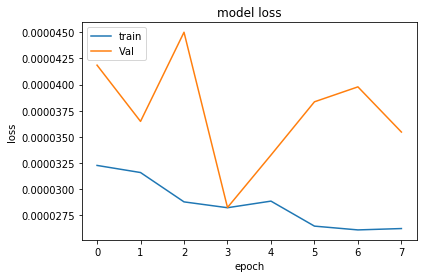

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

In [25]:
model.save("model123_waterflow.hdf5")

In [26]:
predicted_y_values = model.predict(X_Test)

In [27]:
predicted_y_values_unnor = ytest_min_max_scaler.inverse_transform(predicted_y_values)

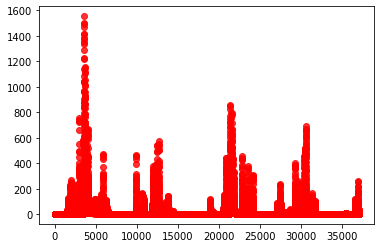

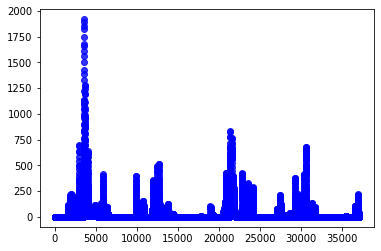

In [28]:
plt.figure()
plt.plot(predicted_y_values_unnor, 'ro', alpha=0.8)
plt.show()
plt.figure()
plt.plot(Y_test_actual, 'bo', alpha=0.8)
plt.show()

In [29]:
mean_square_root = mean_squared_error(predicted_y_values_unnor, Y_test_actual)
mean_square_root

130.755469707972